In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers


import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook
from operator import itemgetter


In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [4]:
counterfact = CounterFactDataset("../data/")

../data/counterfact.json does not exist. Downloading from https://memit.baulab.info/data/dsets/counterfact.json


  0%|          | 0.00/43.0M [00:00<?, ?B/s]

Loaded dataset with 21919 elements


In [36]:
cut_off = 50 # minimum number of correct predictions

# ###########################################################################
relation_dct = {
      'P17'   : {'relation': '{} is located in the country of', 'correct_predict': None, 'cached_JB': None},
      'P641'  : {'relation': '{} plays the sport of', 'correct_predict': None, 'cached_JB': None},
#     'P103'  : {'relation': 'The mother tongue of {} is', 'correct_predict': None, 'cached_JB': None},
#     'P176'  : {'relation': '{} is produced by', 'correct_predict': None, 'cached_JB': None},
#     'P140'  : {'relation': 'The official religion of {} is', 'correct_predict': None, 'cached_JB': None},
#     'P1303' : {'relation': '{} plays the instrument', 'correct_predict': None, 'cached_JB': None},
#     'P190'  : {'relation': 'What is the twin city of {}? It is', 'correct_predict': None, 'cached_JB': None},
#     'P740'  : {'relation': '{} was founded in', 'correct_predict': None, 'cached_JB': None},
      'P178'  : {'relation': '{} was developed by', 'correct_predict': None, 'cached_JB': None},
#     'P495'  : {'relation': '{}, that originated in the country of', 'correct_predict': None, 'cached_JB': None},
#     'P127'  : {'relation': '{} is owned by', 'correct_predict': None, 'cached_JB': None},
#     'P413'  : {'relation': '{} plays in the position of', 'correct_predict': None, 'cached_JB': None},
#     'P39'   : {'relation': '{}, who holds the position of', 'correct_predict': None, 'cached_JB': None},
#     'P159'  : {'relation': 'The headquarter of {} is located in', 'correct_predict': None, 'cached_JB': None},
#     'P20'   : {'relation': '{} died in the city of', 'correct_predict': None, 'cached_JB': None},
#     'P136'  : {'relation': 'What does {} play? They play', 'correct_predict': None, 'cached_JB': None},
#     'P106'  : {'relation': 'The profession of {} is', 'correct_predict': None, 'cached_JB': None},
#     'P30'   : {'relation': '{} is located in the continent of', 'correct_predict': None, 'cached_JB': None},
#     'P937'  : {'relation': '{} worked in the city of', 'correct_predict': None, 'cached_JB': None},
#     'P449'  : {'relation': '{} was released on', 'correct_predict': None, 'cached_JB': None},
      'P27'   : {'relation': '{} is a citizen of', 'correct_predict': None, 'cached_JB': None},
#     'P101'  : {'relation': '{} works in the field of', 'correct_predict': None, 'cached_JB': None},
#     'P19'   : {'relation': '{} was born in', 'correct_predict': None, 'cached_JB': None},
#     'P37'   : {'relation': 'In {}, an official language is', 'correct_predict': None, 'cached_JB': None},
#     'P138'  : {'relation': '{}, named after', 'correct_predict': None, 'cached_JB': None},
#     'P131'  : {'relation': '{} is located in', 'correct_predict': None, 'cached_JB': None},
#     'P407'  : {'relation': '{} was written in', 'correct_predict': None, 'cached_JB': None},
#     'P108'  : {'relation': '{}, who is employed by', 'correct_predict': None, 'cached_JB': None},
      'P36'   : {'relation': 'The capital of {} is', 'correct_predict': None, 'cached_JB': None},
}
###########################################################################

root_path = "gpt-j"

pop_track = []
for relation in relation_dct:
    path = f"{root_path}/{relation}"
    with open(f"{path}/correct_prediction_{relation}.json") as f:
        correct_predictions = json.load(f)
    if(len(correct_predictions) < cut_off):
    # if "performance" not in os.listdir(path):
        print("skipped ", relation)
        pop_track.append(relation)
    
for r in pop_track:
    relation_dct.pop(r)

In [37]:
from relations.corner import CornerEstimator

In [38]:
with open("corner__identity_vs_jacobian.json") as f:
    accuracy_tracker = json.load(f)

In [39]:
lst = []
for r in accuracy_tracker:
    if(r not in relation_dct):
        continue
    dct = {"relation": r}
    for k, v in accuracy_tracker[r].items():
        dct[k] = v
    lst.append(dct) 
lst.sort(key = itemgetter("identity_acc"))

identity_accuracies = []
jacobian_accuracies = []
simple_corner_accuracy = []
lin_env_corner_accuracy = []
freq_accuracies = []
relations = []
for r in lst:
    relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
    identity_accuracies.append(np.array(r["identity_acc"]))
    jacobian_accuracies.append(np.array(r["jacobian_acc"]))
    # simple_corner_accuracy.append(r["identity__simple_corner"])
    # lin_env_corner_accuracy.append(r["identity__lin_inv_corner"])
    freq_accuracies.append(r["freq_acc"])

identity_accuracies = np.stack(identity_accuracies)
jacobian_accuracies = np.stack(jacobian_accuracies)

identity_accuracies.shape, jacobian_accuracies.shape

((5, 10), (5, 10))

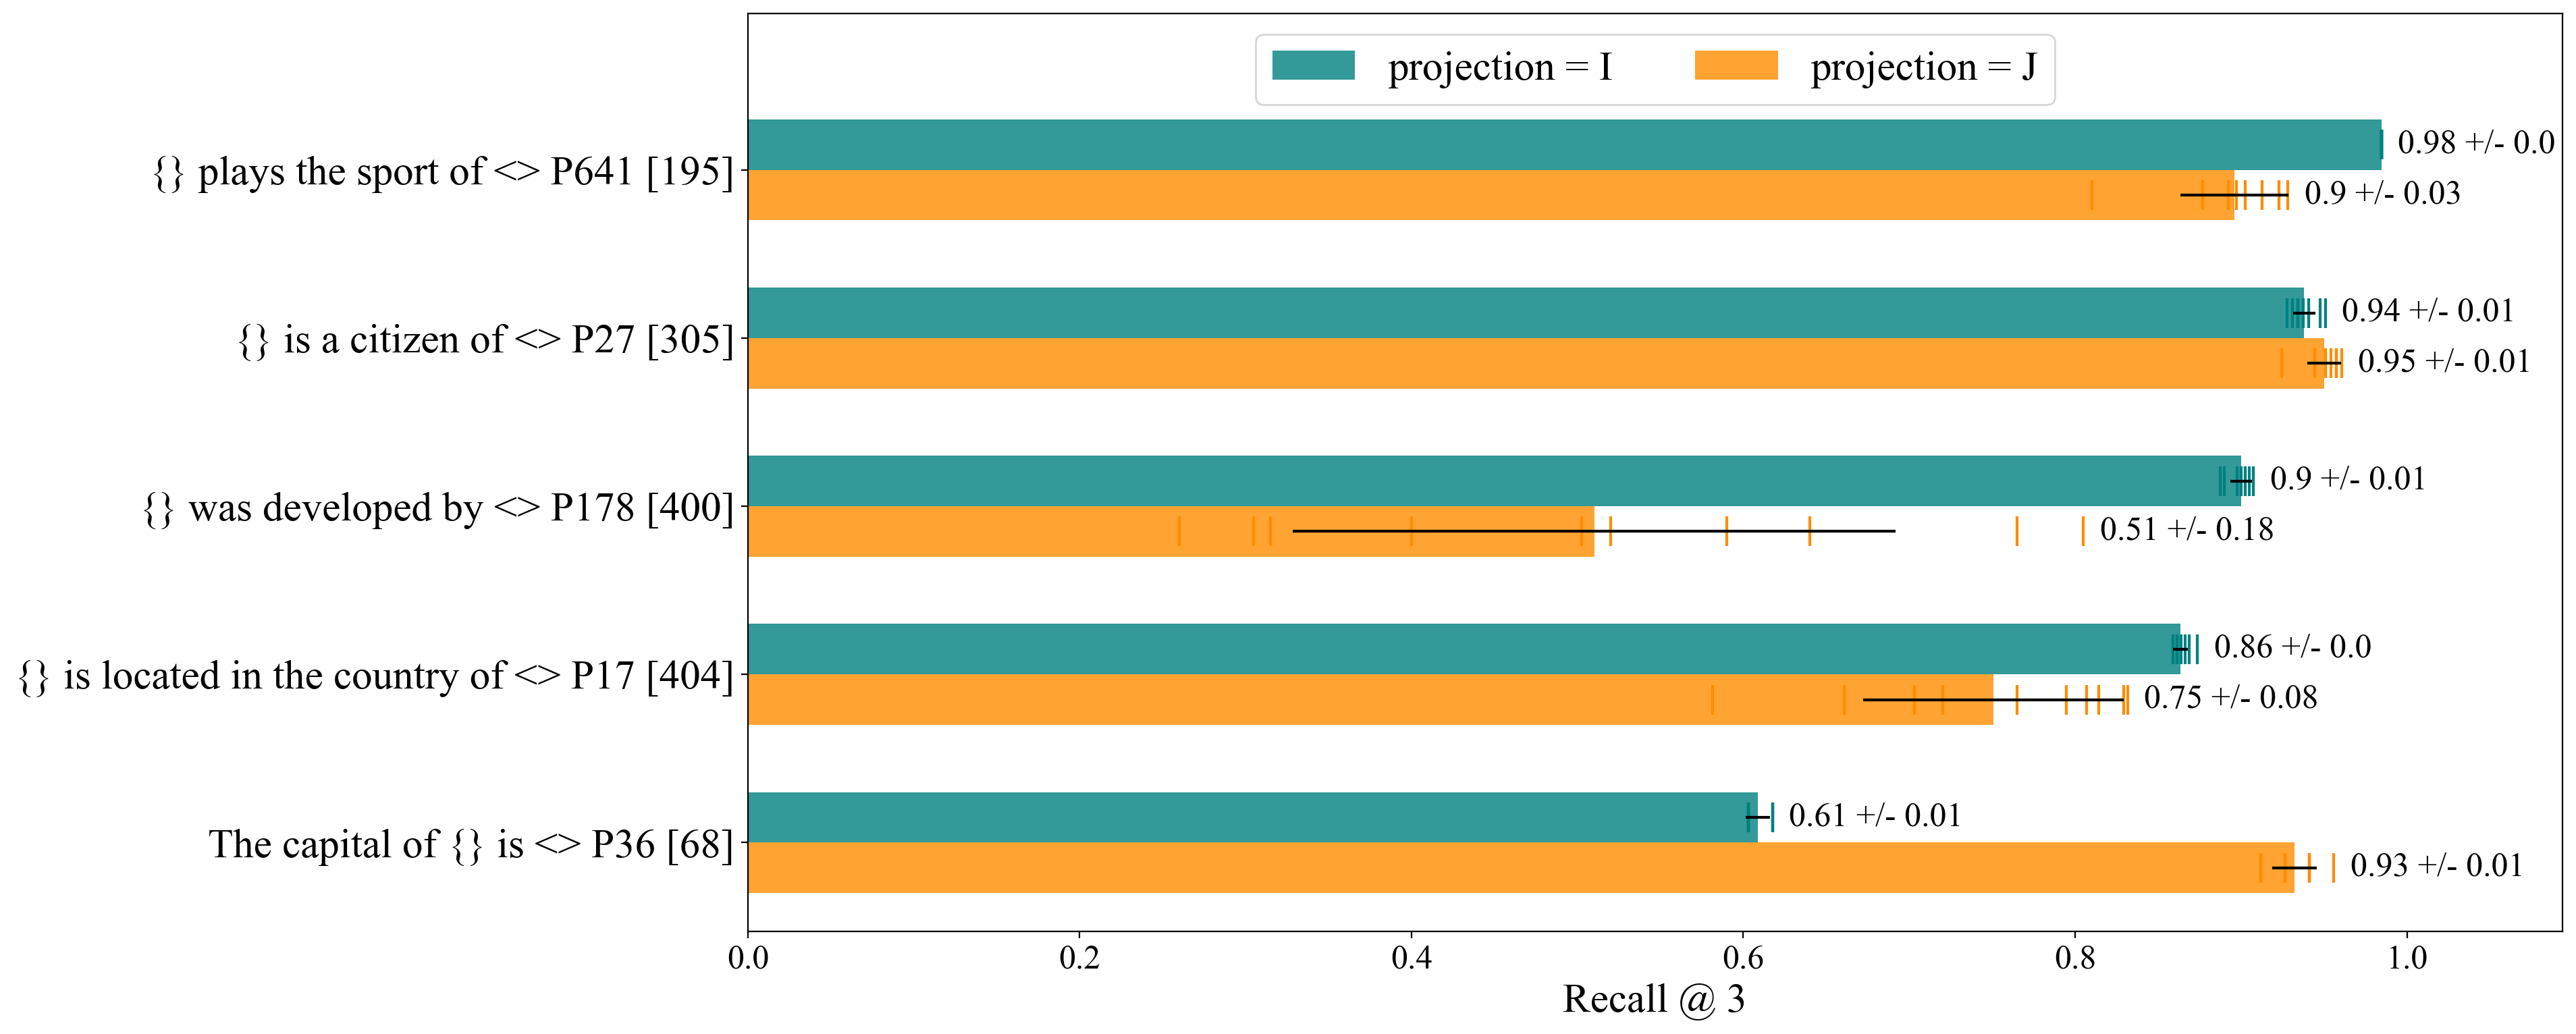

In [78]:
# accuracy_tracker

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE + 5)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


corner_color = "teal"
jacobian_color = "darkorange"
bar_alpha = 0.8

y = np.arange(len(relations))  # the label locations
width = .3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(y + width/2, identity_accuracies.mean(axis = 1), width, label='projection = I', xerr = identity_accuracies.std(axis = 1), color = corner_color, alpha = bar_alpha)
rects2 = ax.barh(y - width/2, jacobian_accuracies.mean(axis = 1), width, label='projection = J', xerr = jacobian_accuracies.std(axis = 1), color = jacobian_color, alpha = bar_alpha)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Recall @ 3')
# ax.set_title(f'Layer {layer} ---- Precision @ 3 with weight = I')
ax.set_yticks(y, relations)
ax.legend(loc="upper center", ncol=2)
# ax.legend(ncol=2)

def add_bar_labels(rects, accuracies, color = "black"):
    labels = [f"{round(acc.mean(), 2)} +/- {round(acc.std(), 2)}" for acc in accuracies]
    for rect, acc, label in zip(rects, accuracies, labels):
        # x_pos = acc.mean() + acc.std() + .01
        x_pos = acc.max() + 0.01
        y_pos = rect.get_y() + rect.get_height() / 2
        ax.text(
            x_pos, y_pos, label, ha="left", va="center",
        )
        points = acc
        ax.scatter(points, [y_pos]*len(points), color = color, marker="|", s = 250)

add_bar_labels(rects1, identity_accuracies, color = corner_color)
add_bar_labels(rects2, jacobian_accuracies, color = jacobian_color)

fig.tight_layout()
plot_margin = 0.06
x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1 + plot_margin, y0, y1 + .4))
# plt.savefig(f"Figures/identity_vs_jacobian.png")
plt.savefig("Figures/identity_vs_jacobian.pdf", format="pdf", bbox_inches="tight")


fig.show()